In [19]:
import numpy as np  # import numpy package (abbreviation stands for Numerical Python)
import matplotlib.pyplot as plt  # we plot graphs with this library

times = np.arange(0, 500)  # linear space of times from 0 to 499 in arbitrary units
wavelengths = np.arange(300, 600)  # linear space of wavelengths from 300 to 599 in arbitrary units

t, w = times.shape[0], wavelengths.shape[0]  # dimensions of times and wavelenths
t, w

(500, 300)

In [35]:
import math
def find_nearest_idx(array, value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx - 1]) < math.fabs(value - array[idx])):
        return idx - 1
    else:
        return idx
def find_nearest(array, value):
    idx = find_nearest_idx(array, value)
    return array[idx]


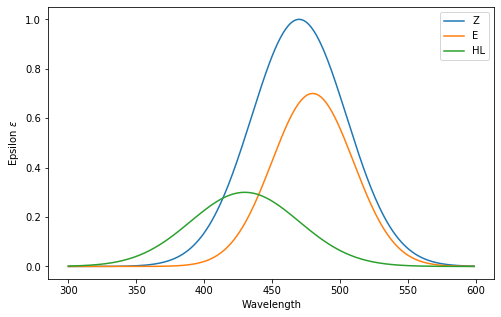

In [96]:
n = 3  # we will have 3 absorbing species

C = np.zeros((t, n))  # define concentration matrix with dimensions t x n
ST = np.zeros((n, w))  # define epsilon matrix with dimensions n x w

# define gaussian function (without a scaling factor) for creating sample spectra
def gauss(x, mu, sigma):
    return np.exp(- (x - mu) * (x - mu) / (2 * sigma * sigma))

# fill epsilon matrix for all 3 species with generated spectra by gaussian function
ST[0] = 1 * gauss(wavelengths, 470, 35)
ST[1] = 0.7 * gauss(wavelengths, 480, 30)
ST[2] = 0.3 * gauss(wavelengths, 430, 40)

names = ['Z', 'E', 'HL']

# plot created spectra
plt.rcParams['figure.figsize'] = [8, 5]
for i in range(n):
    plt.plot(wavelengths, ST[i], label=names[i])
plt.xlabel('Wavelength')
plt.ylabel('Epsilon $\epsilon$')
plt.legend()
plt.show()

In [97]:
idx = find_nearest_idx(wavelengths, 450)
ST[1, idx]


0.42457146179884336

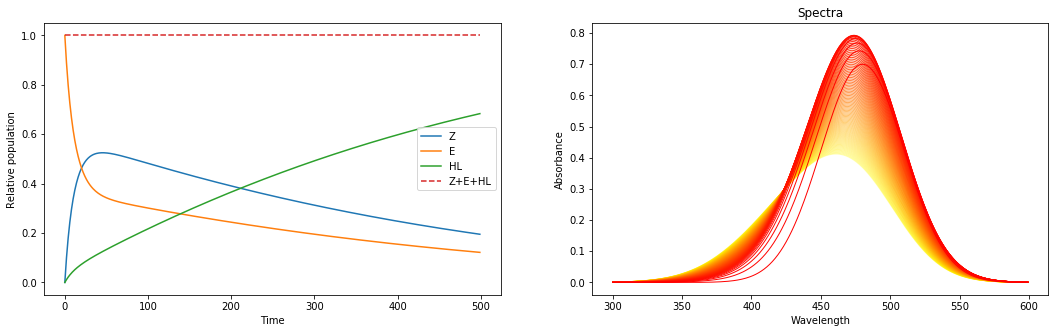

In [169]:
from scipy.integrate import odeint

def solve_C(w_irr):
    idx = find_nearest_idx(wavelengths, w_irr)
    eps_Z = ST[0, idx]
    eps_E = ST[1, idx]
    eps_HL = ST[2, idx]

    Phi_ZE = 0.3  # Z to E isomerizaton
    Phi_EZ = 0.9  # E to Z isomerizaton
    Phi_EHL = 0.1  # E to HL electrocyclization
    Phi_HLBl = 0.0  # HL photobleaching

    def _solve(conc, t):
        cZ, cE, cHL = conc

        At = cE*eps_E + cZ*eps_Z + cHL*eps_HL  # calculate the total absorbance at irr wavelength
        
        f = 0.1 * ((1-10 ** -At) / At)

        dcZ_dt =  f * (Phi_EZ*cE*eps_E - Phi_ZE*cZ*eps_Z)
        dcE_dt =  f * (Phi_ZE*cZ*eps_Z - Phi_EZ*cE*eps_E - Phi_EHL*cE*eps_E)
        dcHL_dt = f * Phi_EHL*cE*eps_E - f * Phi_HLBl*cHL*eps_HL

        return [dcZ_dt, dcE_dt, dcHL_dt]

    result = odeint(_solve, [0, 1, 0], times)

    return result

w_irr = 450
C = solve_C(w_irr)

# plot concentration profiles
plt.rcParams['figure.figsize'] = [18, 5]
plt.subplot(1, 2, 1)
for i in range(n):
    plt.plot(times, C[:, i], label=names[i])
plt.plot(times, C.sum(axis=1), label='+'.join(names), linestyle='--')
plt.xlabel('Time')
plt.ylabel('Relative population')
plt.legend()

D = C @ ST  # compute data matrix

# plot time-dependent spectra
plt.subplot(1, 2, 2)
for i in reversed(range(0, t, 5)):
    plt.plot(wavelengths, D[i], color=(1, i/t, 0, (t-i/1.4)/t), label='$t = {}$'.format(times[i]), lw=1)
plt.title("Spectra")
plt.xlabel('Wavelength')
plt.ylabel('Absorbance')

plt.show()

In [150]:
D.shape

(500, 300)

In [151]:
500*300

150000